In [7]:
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install gTTS
!pip install pyttsx3
!pip install easyocr
!pip install googletrans
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [8]:
!pip install transformers[torch]

In [9]:
!pip install accelerate

In [10]:
!pip install accelerate -U

In [11]:
!pip install transformers[torch] accelerate>=0.21.0


In [16]:
!pip install accelerate==0.19.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.31.0.dev0
    Uninstalling accelerate-0.31.0.dev0:
      Successfully uninstalled accelerate-0.31.0.dev0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-accelerated 0.1.49 requires accelerate==0.29.3, but you have accelerate 0.19.0 which is incompatible.


## Using Pytesseract try to extract text from Image

### 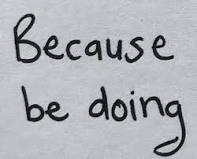

### Install dependencies

In [18]:
import pytesseract
from PIL import Image
import os
import easyocr


In [17]:
def py_ocr(image_path, text_file_path):
    # Opening an image
    img = Image.open(image_path)
    # tessaract module installed path
    pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
    # image to text
    result = pytesseract.image_to_string(img)
    with open(text_file_path, mode='w') as file:
        file.write(result)
    print(result)

py_ocr('/content/images.jfif', 'abc.txt')


Gecause
be aie



### Pytesseract is not giving good result try to use Easyocr For geting Better Result

In [19]:
def easy_ocr(image_path, text_file_path):
    # the EasyOCR reader
    reader = easyocr.Reader(['en'])
    img = Image.open(image_path)
    print(img)
    result = reader.readtext(image_path, detail=0)
    # Convert list to string
    result_text = ' '.join(result)
    print(result_text)
    with open(text_file_path, mode='w') as file:
        file.write(result_text)
easy_ocr('/content/images.jfif', 'abc.txt')


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=197x159 at 0x7FBAF69148E0>
Because be doinq


#### easyocr is something better than tessaract ocr . Now trying to different approach

In [20]:
!pip install kaggle

### Take provided dataset through kaggle

### download kaggle.json file

In [21]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adas754","key":"9eec85e50969c3e607ffdf6487671da6"}'}

### kaggle dataset

In [22]:
!kaggle datasets download -d andrewmvd/car-plate-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
 91% 185M/203M [00:01<00:00, 113MB/s] 
100% 203M/203M [00:02<00:00, 103MB/s]


In [23]:
from zipfile import ZipFile

def extract_zip(zip_file, extract_path):
    """
    Extracts the contents of a zip file to a specified directory.

    Parameters:
        - zip_file (str): Path to the zip file.
        - extract_path (str): Directory path where the contents will be extracted.
    """
    with ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print('Extraction complete.')
zip_file_path = "/content/car-plate-detection.zip"
extract_path = "/content/extracted_files"
extract_zip(zip_file_path, extract_path)


Extraction complete.


## Install some dependencies

In [60]:
import os
import cv2
import pytesseract
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt


### imagepath and annotation path

In [52]:
image_base_path = '/content/extracted_files/images'
annotation_base_path = '/content/extracted_files/annotations'

## Displaying all the images in dataset

In [53]:
def display_image(img, title=""):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

### read xml file

In [54]:
def read_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    boxes = []

    for member in root.findall('object'):
        bndbox = member.find('bndbox')
        if bndbox is not None:
            xmin = bndbox.find('xmin')
            ymin = bndbox.find('ymin')
            xmax = bndbox.find('xmax')
            ymax = bndbox.find('ymax')

            if xmin is not None and ymin is not None and xmax is not None and ymax is not None:
                box = (
                    int(xmin.text),
                    int(ymin.text),
                    int(xmax.text),
                    int(ymax.text)
                )
                boxes.append(box)
    return filename, boxes


## Data Preprocessing for OCR

In [55]:
def preprocess_for_ocr(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply bilateral filter to remove noise while keeping edges sharp
    filtered = cv2.bilateralFilter(gray, 11, 17, 17)
    # Perform edge detection
    edged = cv2.Canny(filtered, 30, 200)
    # Find contours and apply mask
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [cnt], 0, 255, -1)
        img = cv2.bitwise_and(img, img, mask=mask)
        return img
    else:
        return img

### try to do Number plate detection

In [56]:
def detect_number_plate(image_path, annotation_path):
    filename, boxes = read_annotation(annotation_path)
    image = cv2.imread(image_path)
    detected_text = '0'  # Default to '0' if no text is detected

    for box in boxes:
        x_min, y_min, x_max, y_max = box
        number_plate = image[y_min:y_max, x_min:x_max]
        preprocessed_plate = preprocess_for_ocr(number_plate)
        text = pytesseract.image_to_string(preprocessed_plate, config='--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789').strip()
        if text:
            detected_text = text
            break  # only one number plate per image

    return filename, detected_text

## image preprocessing

In [59]:
def process_annotations(annotation_base_path, image_base_path):
    """
    Process images using their corresponding annotations for number plate detection.

    Parameters:
        - annotation_base_path (str): Path to the directory containing annotation files.
        - image_base_path (str): Path to the directory containing image files.

    Returns:
        - tuple: A tuple containing the lists of images with no detection and successful detections.
    """
    # to hold the sorted results
    no_detection = []
    successful_detections = []
    # all the annotation files
    annotation_files = [f for f in os.listdir(annotation_base_path) if f.endswith('.xml')]
    # Process each img with corresponding annotation
    for annotation_file in annotation_files:
        base_name = annotation_file.split('.')[0]
        image_file = base_name + '.png'  # Adjust this if image format is different
        image_path = os.path.join(image_base_path, image_file)
        annotation_path = os.path.join(annotation_base_path, annotation_file)

        if os.path.exists(image_path) and os.path.exists(annotation_path):
            image_name, detected_number = detect_number_plate(image_path, annotation_path)
            if detected_number == '0':
                no_detection.append(image_name)
            else:
                successful_detections.append((image_name, detected_number))

    return no_detection, successful_detections
no_detection, successful_detections = process_annotations(annotation_base_path, image_base_path)


### visualization and summaries

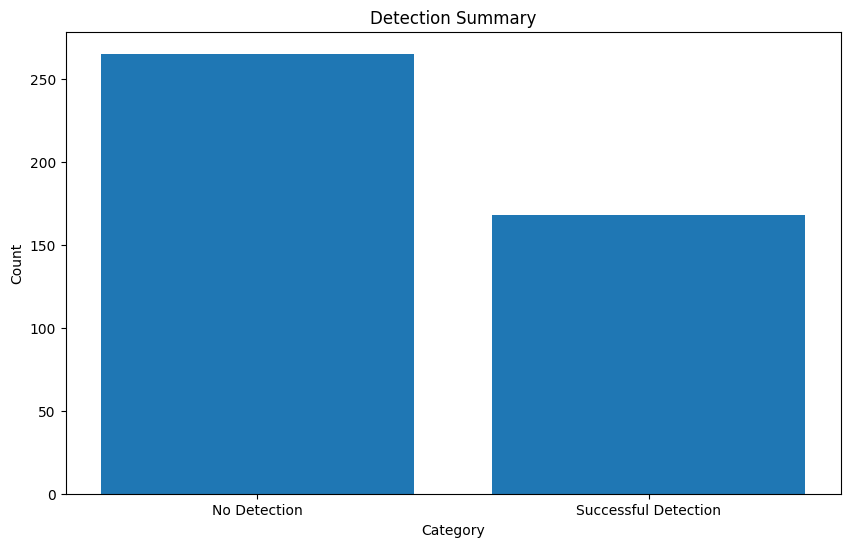

Summary Statistics:
               Category  Count
0          No Detection    265
1  Successful Detection    168
2           Grand Total    433

Detailed Breakdown:
 Image Name Detected Registration Number
  Cars0.png                            0
  Cars1.png                            2
 Cars10.png                            0
Cars100.png                            C
Cars101.png                            0
Cars102.png                            0
Cars103.png                            4
Cars104.png                            0
Cars105.png                           MD
Cars106.png                           ER
Cars107.png                            0
Cars108.png                            0
Cars109.png                            0
 Cars11.png                            0
Cars110.png                           BO
Cars111.png                            0
Cars112.png                            0
Cars113.png                            0
Cars114.png                            0
Cars115.png    

In [61]:
def generate_detection_report(no_detection, successful_detections):
    """
    Generate a detection report including summary statistics, detailed breakdown, and visualization.

    Parameters:
        - no_detection (list): List of image names with no detected number plates.
        - successful_detections (list): List of tuples containing image names and detected number plates.

    Returns:
        - summary_df (DataFrame): Summary statistics dataframe.
        - detailed_df (DataFrame): Detailed breakdown dataframe.
    """
    # Calculate counts
    no_detection_count = len(no_detection)
    successful_detection_count = len(successful_detections)

    # Summary statistics
    summary_df = pd.DataFrame({
        "Category": ["No Detection", "Successful Detection", "Grand Total"],
        "Count": [no_detection_count, successful_detection_count, no_detection_count + successful_detection_count]
    })

    # Detailed breakdown
    detailed_df = pd.DataFrame(successful_detections, columns=["Image Name", "Detected Registration Number"])
    no_detection_df = pd.DataFrame(no_detection, columns=["Image Name"])
    no_detection_df["Detected Registration Number"] = "0"
    combined_detailed_df = pd.concat([detailed_df, no_detection_df]).sort_values("Image Name")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.bar(["No Detection", "Successful Detection"], [no_detection_count, successful_detection_count])
    plt.title("Detection Summary")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()

    return summary_df, combined_detailed_df
summary_df, detailed_df = generate_detection_report(no_detection, successful_detections)
print("Summary Statistics:")
print(summary_df)
print("\nDetailed Breakdown:")
print(detailed_df.to_string(index=False))


#### using Distilbert

In [16]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
supervision==0.9.0

In [17]:
IMAGE_DIR_PATH = f"/content/extracted_files/images"

In [18]:
SAMPLE_SIZE =16
SAMPLE_GRID_SIZE = (4,4)
SAMPLE_PLOT_SIZE = (16,16)

In [19]:
from autodistill.detection import CaptionOntology

ontology = CaptionOntology({
    "license plate": "license plate"
})

In [3]:
!pip install autodistill autodistill-grounded-sam autodistill-yolov8

In [1]:
!pip install roboflow

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PuwNh67WvxBDmH7VOt04")
project = rf.workspace("augmented-startups").project("vehicle-registration-plates-trudk")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.81, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Vehicle-Registration-Plates-2 in yolov8:: 100%|██████████| 42362/42362 [00:13<00:00, 3036.93it/s]


In [20]:
DATASET_DIR_PATH="/content/dataset/train"

In [ ]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension="png",
    output_folder=DATASET_DIR_PATH

)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/extracted_files/images/Cars114.png:   6%|▌         | 24/433 [1:13:26<20:59:00, 184.70s/it]

In [11]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension="png",
    output_folder=DATASET_DIR_PATH

)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling images: 0it [00:00, ?it/s]

Labeled dataset created - ready for distillation.


In [12]:
ANNOTATIONS_DIRECTORY_PATH = f"/content/dataset/annotations"
IMAGES_DIRECTORY_PATH = f"/content/dataset/images"
DATA_YAML_PATH = f"/content/dataset/data.yaml"